# Spatial-Temporal Planner (Development Notebook)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np

### Trajectory Representation

In [3]:
class Trajectory(nn.Module):
    def __init__(self, coeffs, dts):
        super(Trajectory, self).__init__()
        self.coeffs = coeffs # [n_pieces, n_coeffs, n_dims]
        self.dts = dts # [n_pieces]
        # cumulate dts
        self.ts = dts.cumsum(0).detach().numpy()
        self.ts = np.concatenate([[0], self.ts])

    def pos(self, t):
        # t [n_samples]
        # return [n_samples, n_dims]
        
        # split t into intervals based on t >= ts_i and t < ts_i+1
        pos = []
        for i in range(len(self.ts)-1):
            t_ = t[(t >= self.ts[i]) & (t < self.ts[i+1])]
            pos.append(self._pos(t_ - self.ts[i], self.coeffs[i]))
        pos = torch.cat(pos, 0)
        return pos
    
    def _pos(self, t, coeffs):
        # t [n_samples]
        # coeffs [n_coeffs, n_dims]
        # return [n_samples, n_dims]
        
        # compute pos for each dimension
        T = torch.cat([t[:, None]**i for i in range(len(coeffs))], 1)
        pos = T @ coeffs
        return pos
    
    def vel(self, t):
        # t [n_samples]
        # return [n_samples, n_dims]
        
        # split t into intervals based on t >= ts_i and t < ts_i+1
        vel = []
        for i in range(len(self.ts)-1):
            t_ = t[(t >= self.ts[i]) & (t < self.ts[i+1])]
            vel.append(self._vel(t_ - self.ts[i], self.coeffs[i]))
        vel = torch.cat(vel, 0)
        return vel
    
    def _vel(self, t, coeffs):
        # t [n_samples]
        # coeffs [n_coeffs, n_dims]
        # return [n_samples, n_dims]
        
        # compute vel for each dimension
        T = torch.cat([t[:, None]**i for i in range(0, len(coeffs)-1)], 1)
        vel = T @ (torch.arange(1, len(coeffs)).float()[:, None] * coeffs[1:])
        return vel
    
    def acc(self, t):
        # t [n_samples]
        # return [n_samples, n_dims]
        
        # split t into intervals based on t >= ts_i and t < ts_i+1
        acc = []
        for i in range(len(self.ts)-1):
            t_ = t[(t >= self.ts[i]) & (t < self.ts[i+1])]
            acc.append(self._acc(t_ - self.ts[i], self.coeffs[i]))
        acc = torch.cat(acc, 0)
        return acc
    
    def _acc(self, t, coeffs):
        # t [n_samples]
        # coeffs [n_coeffs, n_dims]
        # return [n_samples, n_dims]
        
        # compute acc for each dimension
        T = torch.cat([t[:, None]**i for i in range(0, len(coeffs)-2)], 1)
        acc = T @ (torch.arange(2, len(coeffs)).float()[:, None] * (torch.arange(1, len(coeffs)-1).float()[:, None] * coeffs[2:]))
        return acc
    
    def jerk(self, t):
        # t [n_samples]
        # return [n_samples, n_dims]
        
        # split t into intervals based on t >= ts_i and t < ts_i+1
        jerk = []
        for i in range(len(self.ts)-1):
            t_ = t[(t >= self.ts[i]) & (t < self.ts[i+1])]
            jerk.append(self._jerk(t_ - self.ts[i], self.coeffs[i]))
        jerk = torch.cat(jerk, 0)
        return jerk
    
    def _jerk(self, t, coeffs):
        # t [n_samples]
        # coeffs [n_coeffs, n_dims]
        # return [n_samples, n_dims]
        
        # compute jerk for each dimension
        T = torch.cat([t[:, None]**i for i in range(0, len(coeffs)-3)], 1)
        jerk = T @ (torch.arange(3, len(coeffs)).float()[:, None] * (torch.arange(2, len(coeffs)-1).float()[:, None] * (torch.arange(1, len(coeffs)-2).float()[:, None] * coeffs[3:])))
        return jerk

## Minimum-Control-Effort (MINCO) Polynomials
- start and end conditions
- waypoint position and time allocation parameterization
- mapping from waypoint and time parameterization to minimum energy polynomial coefficients with linear complexity
- additional tricks for efficiency, numerical stability and unconstrained optimization

In [4]:
# initial constraints: position, velocity, acceleration
# polynomial order: 5 (jerk)

class MINCO_S3NU(nn.Module):
    def __init__(self, N):
        super(MINCO_S3NU, self).__init__()
        self.N = N

    def solve_linear(self, headPVA, tailPVA, points, t):
        # headPVA: [B, 3, 3]
        # tailPVA: [B, 3, 3]
        # points: [B, N-1, 3]
        # t: [B, N, 1]
        # return: [B, 1]

        # create a matrix T [B, N, 6] with t^0, t^1, t^2, t^3, t^4, t^5
        T = torch.cat([torch.ones_like(t), t, t**2, t**3, t**4, t**5], dim=-1)
        self.T = T

        assert headPVA.shape[0] == tailPVA.shape[0] == points.shape[0] == t.shape[0], f"Tensors must have the same batch size. Got {headPVA.shape[0]}, {tailPVA.shape[0]}, {points.shape[0]}, {t.shape[0]}"
        
        N = self.N
        B = headPVA.shape[0]
        
        A = torch.zeros(B, 6 * N, 6 * N)
        b = torch.zeros(B, 6 * N, 3)

        # inital constraints
        A[:, 0, 0] = 1.0
        A[:, 1, 1] = 1.0
        A[:, 2, 2] = 2.0
        b[:, 0] = headPVA[:, 0]
        b[:, 1] = headPVA[:, 1]
        b[:, 2] = headPVA[:, 2]

        for i in range(N-1):
            # jerk continuity
            A[:, 6*i+3, 6*i+3] = 6.0
            A[:, 6*i+3, 6*i+4] = 24.0 * T[:, i, 1]
            A[:, 6*i+3, 6*i+5] = 60.0 * T[:, i, 2]
            A[:, 6*i+3, 6*i+9] = -6.0

            # snap continuity
            A[:, 6*i+4, 6*i+4] = 24.0
            A[:, 6*i+4, 6*i+5] = 120.0 * T[:, i, 1]
            A[:, 6*i+4, 6*i+10] = -24.0
            
            # position constaint
            A[:, 6*i+5, 6*i] = T[:, i, 0]
            A[:, 6*i+5, 6*i+1] = T[:, i, 1]
            A[:, 6*i+5, 6*i+2] = T[:, i, 2]
            A[:, 6*i+5, 6*i+3] = T[:, i, 3]
            A[:, 6*i+5, 6*i+4] = T[:, i, 4]
            A[:, 6*i+5, 6*i+5] = T[:, i, 5]

            b[:, 6*i+5] = points[:, i]

            # position continuity
            A[:, 6*i+6, 6*i] = T[:, i, 0]
            A[:, 6*i+6, 6*i+1] = T[:, i, 1]
            A[:, 6*i+6, 6*i+2] = T[:, i, 2]
            A[:, 6*i+6, 6*i+3] = T[:, i, 3]
            A[:, 6*i+6, 6*i+4] = T[:, i, 4]
            A[:, 6*i+6, 6*i+5] = T[:, i, 5]
            A[:, 6*i+6, 6*i+6] = -T[:, i, 0]

            # velocity continuity
            A[:, 6*i+7, 6*i+1] = T[:, i, 0]
            A[:, 6*i+7, 6*i+2] = 2.0 * T[:, i, 1]
            A[:, 6*i+7, 6*i+3] = 3.0 * T[:, i, 2]
            A[:, 6*i+7, 6*i+4] = 4.0 * T[:, i, 3]
            A[:, 6*i+7, 6*i+5] = 5.0 * T[:, i, 4]
            A[:, 6*i+7, 6*i+7] = -1.0

            # acceleration continuity
            A[:, 6*i+8, 6*i+2] = 2.0
            A[:, 6*i+8, 6*i+3] = 6.0 * T[:, i, 1]
            A[:, 6*i+8, 6*i+4] = 12.0 * T[:, i, 2]
            A[:, 6*i+8, 6*i+5] = 20.0 * T[:, i, 3]
            A[:, 6*i+8, 6*i+8] = -2.0

        # final constraints
        # position
        A[:, 6*N-3, 6*N-6] = T[:, N-1, 0]
        A[:, 6*N-3, 6*N-5] = T[:, N-1, 1]
        A[:, 6*N-3, 6*N-4] = T[:, N-1, 2]
        A[:, 6*N-3, 6*N-3] = T[:, N-1, 3]
        A[:, 6*N-3, 6*N-2] = T[:, N-1, 4]
        A[:, 6*N-3, 6*N-1] = T[:, N-1, 5]

        # velocity
        A[:, 6*N-2, 6*N-5] = T[:, N-1, 0]
        A[:, 6*N-2, 6*N-4] = 2.0 * T[:, N-1, 1]
        A[:, 6*N-2, 6*N-3] = 3.0 * T[:, N-1, 2]
        A[:, 6*N-2, 6*N-2] = 4.0 * T[:, N-1, 3]
        A[:, 6*N-2, 6*N-1] = 5.0 * T[:, N-1, 4]

        # acceleration
        A[:, 6*N-1, 6*N-4] = 2.0
        A[:, 6*N-1, 6*N-3] = 6.0 * T[:, N-1, 1]
        A[:, 6*N-1, 6*N-2] = 12.0 * T[:, N-1, 2]
        A[:, 6*N-1, 6*N-1] = 20.0 * T[:, N-1, 3]

        b[:, 6*N-3] = tailPVA[:, 0]
        b[:, 6*N-2] = tailPVA[:, 1]
        b[:, 6*N-1] = tailPVA[:, 2]

        # solve the linear system
        x = torch.linalg.solve(A, b)

        self.A = A
        self.x = x

    def get_energy(self):
        energy = 0.0
        for i in range(self.N-1):
            energy += 36.0 * self.x[:, 6*i+3].pow(2).sum() * self.T[:, i, 1] \
                    + 144.0 * (self.x[:, 6*i+4] * self.x[:, 6*i+3]).sum() * self.T[:, i, 2] \
                    + 192.0 * self.x[:, 6*i+4].pow(2).sum() * self.T[:, i, 3] \
                    + 240.0 * (self.x[:, 6*i+5] * self.x[:, 6*i+3]).sum() * self.T[:, i, 3] \
                    + 720.0 * (self.x[:, 6*i+5] * self.x[:, 6*i+4]).sum() * self.T[:, i, 4] \
                    + 720.0 * self.x[:, 6*i+5].pow(2).sum() * self.T[:, i, 5]
        return energy

    # forward pass
    def forward(self, headPVA, tailPVA, points, t):
        self.solve_linear(headPVA, tailPVA, points, t)
        energy = self.get_energy()
        return energy
    
    def get_trajectory(self):
        trajs = []
        for i in range(self.x.shape[0]):
            coeffs = self.x[i].view(self.N, 6, 3)
            traj = Trajectory(coeffs, self.T[i, :, 1])
            trajs.append(traj)
        return trajs

In [5]:
# initial + waypoint constraints: position, velocity
# polynomial order: 5 (jerk)

class MINCO_S3NU_PV(nn.Module):
    def __init__(self, N):
        super(MINCO_S3NU_PV, self).__init__()
        self.N = N

    def solve_linear(self, headPVA, tailPVA, pos, vel, t):
        # headPVA: [B, 3, 3]
        # tailPVA: [B, 3, 3]
        # pos: [B, N-1, 3]
        # vel: [B, N-1, 3]
        # t: [B, N, 1]
        # return: [B, 1]

        # create a matrix T [B, N, 6] with t^0, t^1, t^2, t^3, t^4, t^5
        T = torch.cat([torch.ones_like(t), t, t**2, t**3, t**4, t**5], dim=-1)
        self.T = T

        assert headPVA.shape[0] == tailPVA.shape[0] == pos.shape[0] == vel.shape[0] == t.shape[0], f"Tensors must have the same batch size. Got {headPVA.shape[0]}, {tailPVA.shape[0]}, {pos.shape[0]}, {vel.shape[0]}, {t.shape[0]}"
        
        N = self.N
        B = headPVA.shape[0]
        
        A = torch.zeros(B, 6 * N, 6 * N)
        b = torch.zeros(B, 6 * N, 3)

        # inital constraints
        A[:, 0, 0] = 1.0
        A[:, 1, 1] = 1.0
        A[:, 2, 2] = 2.0
        b[:, 0] = headPVA[:, 0]
        b[:, 1] = headPVA[:, 1]
        b[:, 2] = headPVA[:, 2]

        for i in range(N-1):
            # jerk continuity
            A[:, 6*i+3, 6*i+3] = 6.0
            A[:, 6*i+3, 6*i+4] = 24.0 * T[:, i, 1]
            A[:, 6*i+3, 6*i+5] = 60.0 * T[:, i, 2]
            A[:, 6*i+3, 6*i+9] = -6.0
            
            # position constaint
            A[:, 6*i+4, 6*i] = T[:, i, 0]
            A[:, 6*i+4, 6*i+1] = T[:, i, 1]
            A[:, 6*i+4, 6*i+2] = T[:, i, 2]
            A[:, 6*i+4, 6*i+3] = T[:, i, 3]
            A[:, 6*i+4, 6*i+4] = T[:, i, 4]
            A[:, 6*i+4, 6*i+5] = T[:, i, 5]

            b[:, 6*i+4] = pos[:, i]

            # velocity constaint
            A[:, 6*i+5, 6*i+1] = T[:, i, 0]
            A[:, 6*i+5, 6*i+2] = 2.0 * T[:, i, 1]
            A[:, 6*i+5, 6*i+3] = 3.0 * T[:, i, 2]
            A[:, 6*i+5, 6*i+4] = 4.0 * T[:, i, 3]
            A[:, 6*i+5, 6*i+5] = 5.0 * T[:, i, 4]

            b[:, 6*i+5] = vel[:, i]

            # position continuity
            A[:, 6*i+6, 6*i] = T[:, i, 0]
            A[:, 6*i+6, 6*i+1] = T[:, i, 1]
            A[:, 6*i+6, 6*i+2] = T[:, i, 2]
            A[:, 6*i+6, 6*i+3] = T[:, i, 3]
            A[:, 6*i+6, 6*i+4] = T[:, i, 4]
            A[:, 6*i+6, 6*i+5] = T[:, i, 5]
            A[:, 6*i+6, 6*i+6] = -T[:, i, 0]

            # velocity continuity
            A[:, 6*i+7, 6*i+1] = T[:, i, 0]
            A[:, 6*i+7, 6*i+2] = 2.0 * T[:, i, 1]
            A[:, 6*i+7, 6*i+3] = 3.0 * T[:, i, 2]
            A[:, 6*i+7, 6*i+4] = 4.0 * T[:, i, 3]
            A[:, 6*i+7, 6*i+5] = 5.0 * T[:, i, 4]
            A[:, 6*i+7, 6*i+7] = -1.0

            # acceleration continuity
            A[:, 6*i+8, 6*i+2] = 2.0
            A[:, 6*i+8, 6*i+3] = 6.0 * T[:, i, 1]
            A[:, 6*i+8, 6*i+4] = 12.0 * T[:, i, 2]
            A[:, 6*i+8, 6*i+5] = 20.0 * T[:, i, 3]
            A[:, 6*i+8, 6*i+8] = -2.0

        # final constraints
        # position
        A[:, 6*N-3, 6*N-6] = T[:, N-1, 0]
        A[:, 6*N-3, 6*N-5] = T[:, N-1, 1]
        A[:, 6*N-3, 6*N-4] = T[:, N-1, 2]
        A[:, 6*N-3, 6*N-3] = T[:, N-1, 3]
        A[:, 6*N-3, 6*N-2] = T[:, N-1, 4]
        A[:, 6*N-3, 6*N-1] = T[:, N-1, 5]

        # velocity
        A[:, 6*N-2, 6*N-5] = T[:, N-1, 0]
        A[:, 6*N-2, 6*N-4] = 2.0 * T[:, N-1, 1]
        A[:, 6*N-2, 6*N-3] = 3.0 * T[:, N-1, 2]
        A[:, 6*N-2, 6*N-2] = 4.0 * T[:, N-1, 3]
        A[:, 6*N-2, 6*N-1] = 5.0 * T[:, N-1, 4]

        # acceleration
        A[:, 6*N-1, 6*N-4] = 2.0
        A[:, 6*N-1, 6*N-3] = 6.0 * T[:, N-1, 1]
        A[:, 6*N-1, 6*N-2] = 12.0 * T[:, N-1, 2]
        A[:, 6*N-1, 6*N-1] = 20.0 * T[:, N-1, 3]

        b[:, 6*N-3] = tailPVA[:, 0]
        b[:, 6*N-2] = tailPVA[:, 1]
        b[:, 6*N-1] = tailPVA[:, 2]

        # solve the linear system
        x = torch.linalg.solve(A, b)

        self.A = A
        self.x = x

    def get_energy(self):
        energy = 0.0
        for i in range(self.N-1):
            energy += 36.0 * self.x[:, 6*i+3].pow(2).sum() * self.T[:, i, 1] \
                    + 144.0 * (self.x[:, 6*i+4] * self.x[:, 6*i+3]).sum() * self.T[:, i, 2] \
                    + 192.0 * self.x[:, 6*i+4].pow(2).sum() * self.T[:, i, 3] \
                    + 240.0 * (self.x[:, 6*i+5] * self.x[:, 6*i+3]).sum() * self.T[:, i, 3] \
                    + 720.0 * (self.x[:, 6*i+5] * self.x[:, 6*i+4]).sum() * self.T[:, i, 4] \
                    + 720.0 * self.x[:, 6*i+5].pow(2).sum() * self.T[:, i, 5]
        return energy

    # forward pass
    def forward(self, headPVA, tailPVA, pos, vel, t):
        self.solve_linear(headPVA, tailPVA, pos, vel, t)
        energy = self.get_energy()
        return energy
    
    def get_trajectory(self):
        trajs = []
        for i in range(self.x.shape[0]):
            coeffs = self.x[i].view(self.N, 6, 3)
            traj = Trajectory(coeffs, self.T[i, :, 1])
            trajs.append(traj)
        return trajs

## Tests

### Validate MINCO Polynomial Implementation

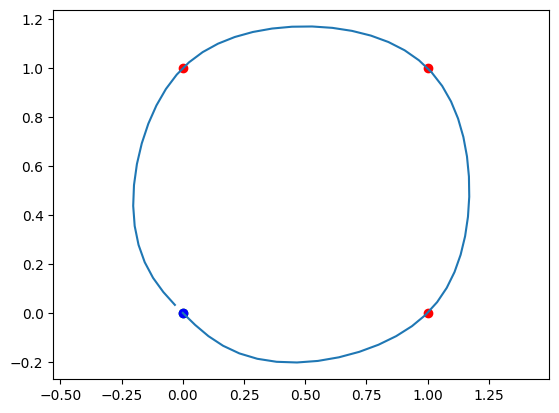

In [6]:
# inital and final position, velocity, acceleration
headPVA = torch.tensor([[0.0, 0.0, 0.0], [np.sqrt(2)/2, -np.sqrt(2)/2, 0.0], [0.0, 0.0, 0.0]], dtype=torch.float32).unsqueeze(0)
tailPVA = torch.tensor([[0.0, 0.0, 0.0], [np.sqrt(2)/2, -np.sqrt(2)/2, 0.0], [0.0, 0.0, 0.0]], dtype=torch.float32).unsqueeze(0)

# waypoints
pos = torch.tensor([[[1.0, 0.0, 0.0], [1.0, 1.0, 0.0], [0.0, 1.0, 0.0]]], dtype=torch.float32)
vel = torch.tensor([[[np.sqrt(2)/2, np.sqrt(2)/2, 0.0], [-np.sqrt(2)/2, np.sqrt(2)/2, 0.0], [-np.sqrt(2)/2, -np.sqrt(2)/2, 0.0]]], dtype=torch.float32)

# timestamps
t = torch.tensor([[[1.0], [1.0], [1.0], [1.0]]], dtype=torch.float32)

# 4 piecewise polynomial
model = MINCO_S3NU_PV(4)

# energy
energy = model(headPVA, tailPVA, pos, vel, t)
trajs = model.get_trajectory()

# sample points
traj = trajs[0]
t = torch.linspace(0, 7.0-0.01, 100)
pos_ = traj.pos(t)
vel_ = traj.vel(t)

import matplotlib.pyplot as plt

# plot x-y
plt.plot(pos_[:, 0], pos_[:, 1])
plt.scatter(pos[0, :, 0], pos[0, :, 1], c='r')
# initial and final position
plt.scatter(headPVA[0, 0, 0], headPVA[0, 0, 1], c='g')
plt.scatter(tailPVA[0, 0, 0], tailPVA[0, 0, 1], c='b')
plt.axis('equal')
plt.show()


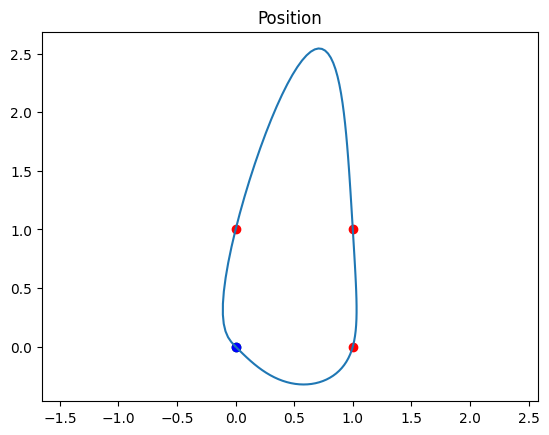

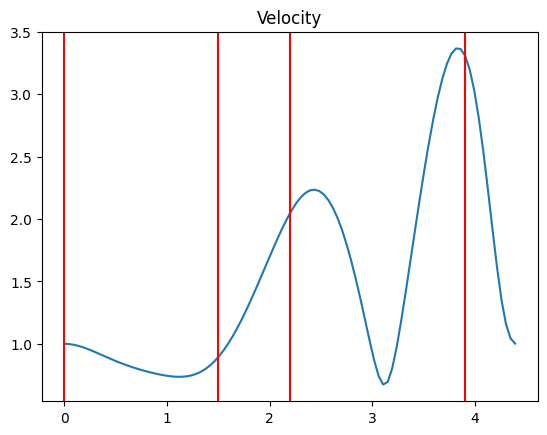

In [7]:
# inital and final position, velocity, acceleration
headPVA = torch.tensor([[0.0, 0.0, 0.0], [np.sqrt(2)/2, -np.sqrt(2)/2, 0.0], [0.0, 0.0, 0.0]], dtype=torch.float32).unsqueeze(0)
tailPVA = torch.tensor([[0.0, 0.0, 0.0], [np.sqrt(2)/2, -np.sqrt(2)/2, 0.0], [0.0, 0.0, 0.0]], dtype=torch.float32).unsqueeze(0)

# waypoints
points = torch.tensor([[[1.0, 0.0, 0.0], [1.0, 1.0, 0.0], [0.0, 1.0, 0.0]]], dtype=torch.float32)

# timestamps
t = torch.tensor([[[1.5], [0.7], [1.7], [0.5]]], dtype=torch.float32)

model = MINCO_S3NU(4)
energy = model(headPVA, tailPVA, points, t)
trajs = model.get_trajectory()

traj = trajs[0]
t_ = torch.linspace(0, 4.4-0.01, 100)
pos_ = traj.pos(t_)
vel_ = traj.vel(t_)

import matplotlib.pyplot as plt

# plot x-y
plt.figure()
plt.plot(pos_[:, 0], pos_[:, 1])
plt.scatter(points[0, :, 0], points[0, :, 1], c='r')
# initial and final position
plt.scatter(headPVA[0, 0, 0], headPVA[0, 0, 1], c='g')
plt.scatter(tailPVA[0, 0, 0], tailPVA[0, 0, 1], c='b')
plt.title("Position")
plt.axis('equal')
plt.show()

plt.figure()
plt.title("Velocity")
plt.plot(t_, vel_.norm(dim=-1))
# plot vertical lines at t
for i in range(t.shape[1]):
    plt.axvline(t[0,0:i].sum(), c='r')
plt.show()


### Validate gradient-based optimization of MINCO Polynomials

torch.Size([1, 4, 1])
Duration: tensor(4.4000)


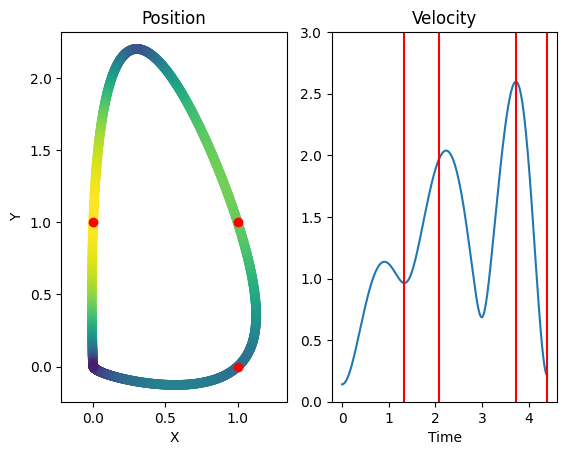

Duration: tensor(4.4000)


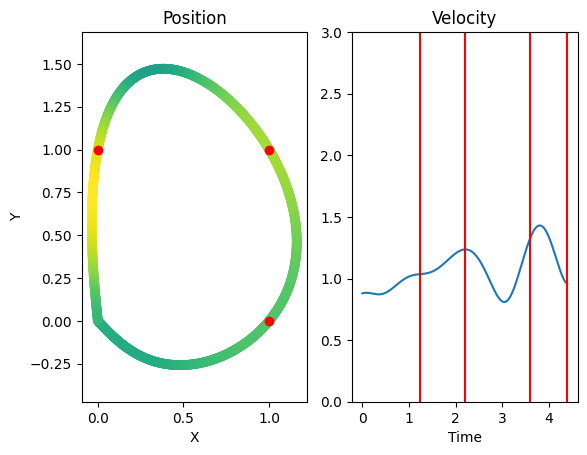

Duration: tensor(4.4000)


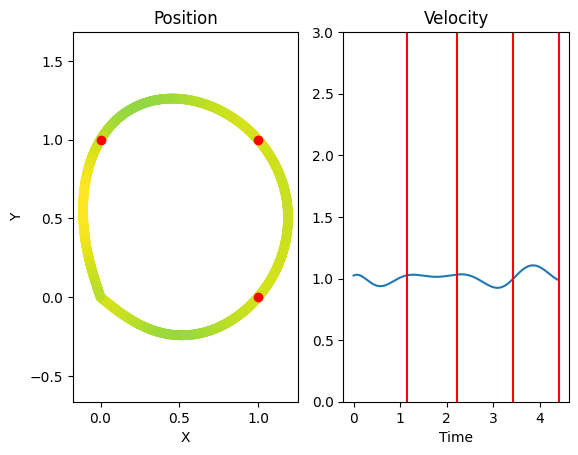

Duration: tensor(4.4000)


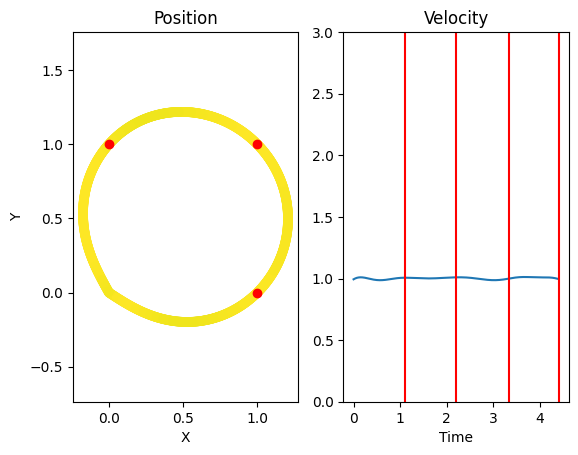

Duration: tensor(4.4000)


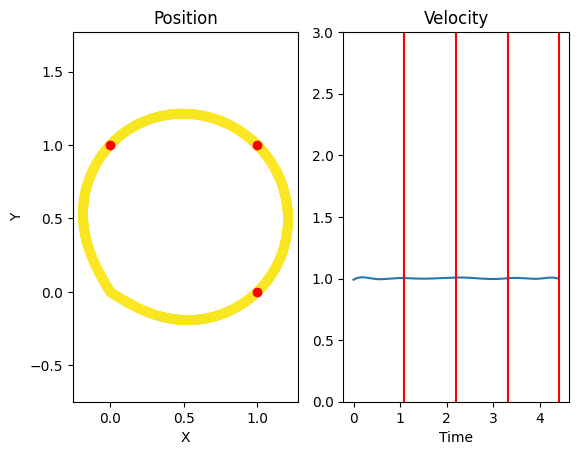

In [8]:
# create optimization loop
# headPVA and tailPVA are fixed
# points are optimized
# energy is minimized

headPVA_pos = torch.tensor([[0.0, 0.0, 0.0]], dtype=torch.float32)
# headPVA_vel = torch.tensor([[np.sqrt(2)/2, -np.sqrt(2)/2, 0.0]], dtype=torch.float32, requires_grad=True)
headPVA_vel = torch.tensor([[0.0, 0.0, 0.0]], dtype=torch.float32, requires_grad=True)
headPVA_acc = torch.tensor([[0.0, 0.0, 0.0]], dtype=torch.float32, requires_grad=True)
headPVA = torch.cat([headPVA_pos, headPVA_vel, headPVA_acc], 0).unsqueeze(0)
tailPVA_pos = torch.tensor([[0.0, 0.0, 0.0]], dtype=torch.float32)
# tailPVA_vel = torch.tensor([[np.sqrt(2)/2, -np.sqrt(2)/2, 0.0]], dtype=torch.float32, requires_grad=True)
tailPVA_vel = torch.tensor([[0.0, 0.0, 0.0]], dtype=torch.float32, requires_grad=True)
tailPVA_acc = torch.tensor([[0.0, 0.0, 0.0]], dtype=torch.float32, requires_grad=True)
tailPVA = torch.cat([tailPVA_pos, tailPVA_vel, tailPVA_acc], 0).unsqueeze(0)

points = torch.tensor([[[1.0, 0.0, 0.0], [1.0, 1.0, 0.0], [0.0, 1.0, 0.0]]], dtype=torch.float32)
tau = torch.tensor([[[1.5], [0.7], [1.7], [0.5]]], dtype=torch.float32, requires_grad=True)
print(tau.shape)
T_total = 4.4

# create optimizer
optimizer = torch.optim.LBFGS([tau, headPVA_vel, headPVA_acc, tailPVA_vel, tailPVA_acc], lr=0.05)

def closure():
    optimizer.zero_grad()
    # headPVA = torch.cat([tailP, tailV, tailA], 0).unsqueeze(0)
    # tailPVA = torch.cat([tailP, tailV, tailA], 0).unsqueeze(0)
    t = torch.softmax(tau, dim=-2) * T_total
    headPVA = torch.cat([headPVA_pos, headPVA_vel, headPVA_acc], 0).unsqueeze(0)
    tailPVA = torch.cat([tailPVA_pos, tailPVA_vel, tailPVA_acc], 0).unsqueeze(0)

    # solve linear
    _ = model(headPVA, tailPVA, points, t)
    trajs = model.get_trajectory()
    traj = trajs[0]

    # compute cost along trajectory
    t_ = torch.linspace(0, traj.ts[-1], 100)
    vel = traj.vel(t_)
    total_vel = vel.norm(dim=-1)
    cost = (total_vel - 1.0).pow(2).sum()

    # gradient
    cost.backward()
    return cost

for i in range(10):
    optimizer.step(closure)
    if i % 2 == 0:
        trajs = model.get_trajectory()
        traj = trajs[0]
        t_ = torch.linspace(0, traj.ts[-1], 1000)
        print("Duration:", t_[-1])
        pos = traj.pos(t_).detach().numpy()
        vel = traj.vel(t_).norm(dim=-1).detach().numpy()
        # color coding based on velocity
        plt.figure()
        cmap = plt.get_cmap('viridis')
        colors = cmap(vel/vel.max())
        ts = torch.softmax(tau, dim=-2) * T_total
        ts = ts.detach().numpy()
        plt.subplot(121)
        plt.title("Position")
        plt.scatter(pos[:, 0], pos[:, 1], c=colors)
        plt.scatter(points[0, :, 0], points[0, :, 1], c='r')
        plt.axis('equal')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.subplot(122)
        plt.title("Velocity")
        plt.plot(t_[:-1], vel)
        for i in range(ts.shape[1]):
            plt.axvline(ts[0,0:i+1].sum(), c='r')
        # set ylim to 0 - 3
        plt.ylim(0, 3)
        plt.xlabel("Time")
        plt.show()